<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-up" data-toc-modified-id="Set-up-1">Set up</a></span></li><li><span><a href="#Do-triangulation" data-toc-modified-id="Do-triangulation-2">Do triangulation</a></span></li><li><span><a href="#Compare-orig-vs-compressed" data-toc-modified-id="Compare-orig-vs-compressed-3">Compare orig vs compressed</a></span></li></ul></div>

In [1]:
# nb: do not use ipyflow kernel with h5 files!

In [1]:
import multicam_calibration as mcc
import matplotlib.pyplot as plt
import numpy as np
import joblib
import h5py
import glob
import tqdm
from os.path import join, exists
import os
from warnings import warn
from moseq_fo.util.file_utils import find_file_from_pattern

In [2]:
%matplotlib inline

## Set up

In [3]:
# Find calibration files and sort by date
calib_paths = glob.glob('/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/calibration/data/*_calibration')
calib_paths = sorted(calib_paths)
calib_date_strs = {c[77:85]: c for c in calib_paths if exists(join(c, 'camera_params.h5'))}

In [4]:
# Find all videos we have calibration files for
vid_dirs = glob.glob('/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01[67]0[1234]/202309*_*')
calib_dict = {}
for vd in vid_dirs:
    date_str = vd[67:75]
    if date_str not in calib_date_strs: continue
    calib_dict[vd] = calib_date_strs[date_str]
# calib_dict

In [5]:
calib_dict.pop('/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01601/20230904_J01601')

'/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/calibration/data/20230904_calibration'

In [6]:
calib_dict.pop('/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01703/20230904_J01703')

'/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/calibration/data/20230904_calibration'

## Do triangulation

In [7]:
# oh yikes this takes forever. def do this in batches too.
# cf: 20230928_avi_compression/train_hrnet-v2/batch_gen.ipynb

In [14]:
# Save out the robust triangulations

for video_dir, calib_dir in calib_dict.items():
#     print(video_dir, calib_dir)
    print()
    print(video_dir)
    
    calib_file = find_file_from_pattern(calib_dir, 'camera_params.h5', [])
    all_extrinsics, all_intrinsics, camera_names = mcc.load_calibration(calib_file, 'gimbal')

    for suffix in ['.COMPRESSED']:
        fname = join(video_dir, 'robust_triangulation' + suffix + '.npy')
        if exists(fname): 
            print(f'{os.path.basename(fname)} exists, continuing...')
            continue
        
        all_uvs = []
        do_triang_flag = True
        for c in camera_names:
            kp_file = join(video_dir, c + suffix + '.keypoints.h5')
            try:
                with h5py.File(kp_file,'r') as h5:
                    uvs = h5['uv'][()]
                    confs = h5['conf'][()]
                    uvs[confs < 0.25] = np.nan  # remove low confidence detections
                    all_uvs.append(uvs)
            except OSError:
                warn(f'{kp_file} could not be loaded, skipping this session...')
                do_triang_flag = False
                break
                
        if do_triang_flag:
            all_uvs = np.array(all_uvs)

            # Save the triangulations
            poses = []
            for i in tqdm.tqdm(range(len(all_uvs[0]))):
                pts = mcc.triangulate(all_uvs[:,i], all_extrinsics, all_intrinsics)
                poses.append(pts)
            np.save(fname, np.array(poses))
#             print("WOULD RUN")
        else:
            continue


/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01601/20230905_J01601
robust_triangulation.COMPRESSED.npy exists, continuing...

/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01703/20230908_J01703
robust_triangulation.COMPRESSED.npy exists, continuing...

/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01701/20230904_J01701


/tmp/ipykernel_2276/3844905007.py:28: UserWarning: /n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01701/20230904_J01701/side1.24548223.COMPRESSED.keypoints.h5 could not be loaded, skipping this session...
  warn(f'{kp_file} could not be loaded, skipping this session...')



/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01701/20230905_J01701


100%|██████████████████████████████████████████████████████████████████████| 216001/216001 [34:26<00:00, 104.51it/s]



/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01602/20230904_J01602


100%|██████████████████████████████████████████████████████████████████████| 324001/324001 [51:59<00:00, 103.86it/s]



/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01602/20230905_J01602

/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01702/20230904_J01702

/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01702/20230905_J01702


/tmp/ipykernel_2276/3844905007.py:28: UserWarning: /n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01602/20230905_J01602/top.24562653.COMPRESSED.keypoints.h5 could not be loaded, skipping this session...
  warn(f'{kp_file} could not be loaded, skipping this session...')
/tmp/ipykernel_2276/3844905007.py:28: UserWarning: /n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01702/20230904_J01702/top.24562653.COMPRESSED.keypoints.h5 could not be loaded, skipping this session...
  warn(f'{kp_file} could not be loaded, skipping this session...')
100%|██████████████████████████████████████████████████████████████████████| 216001/216001 [34:11<00:00, 105.27it/s]


## Compare orig vs compressed

/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01601/20230905_J01601 /n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/calibration/data/20230905_calibration
0.6663277777777777
0.7308228395061729
0.7634873456790123
0.6891805555555556
0.7026858024691358
0.5746425925925925
0.6657848806255526
0.7038735931778094
0.7535196596312054
0.6717080013518456
0.6845604109857516
0.5737683313194538
/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01703/20230908_J01703 /n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/calibration/data/20230908_calibration
0.6365388888888889
0.7007586419753087
0.6968197530864197
0.7463882716049383
0.7125842592592593
0.5700864197530864
0.6384992044789916
0.6777894546784505
0.6791141399036733
0.739160775490237
0.702413106112163
0.5710127885210408
/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01701/20230904_J01701 /n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/calibration/data/20230904_calibration
0.6

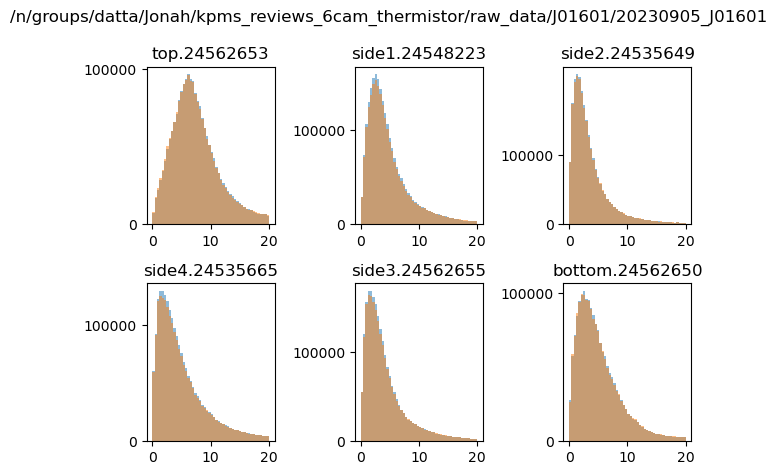

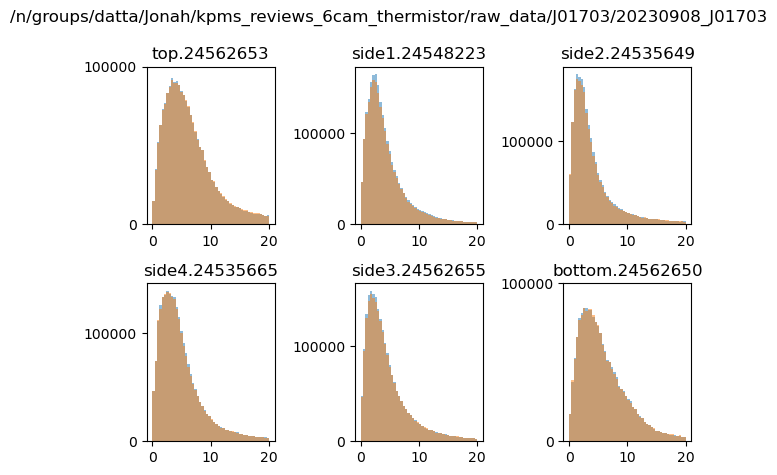

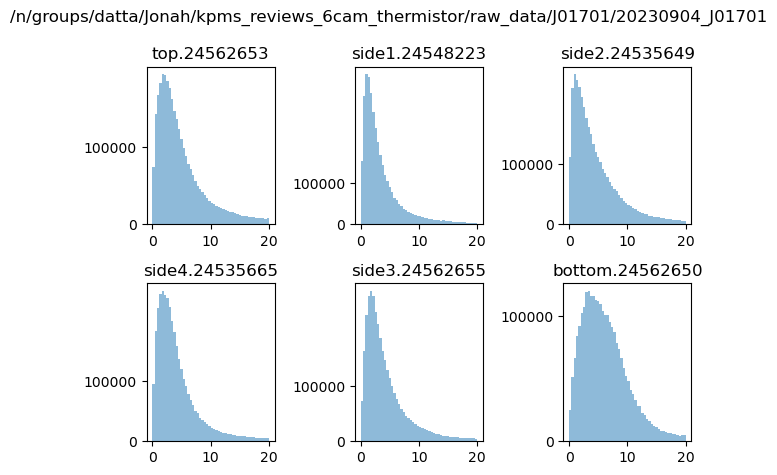

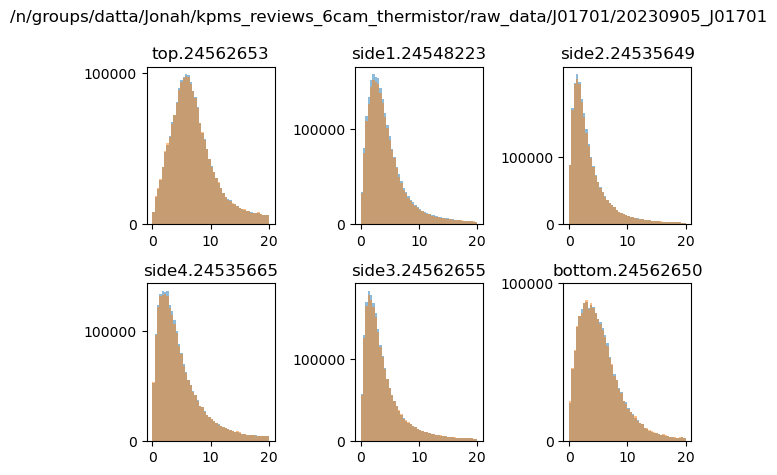

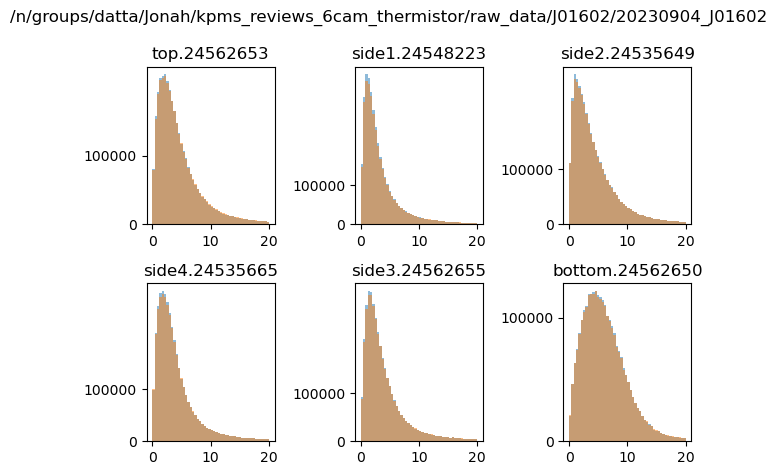

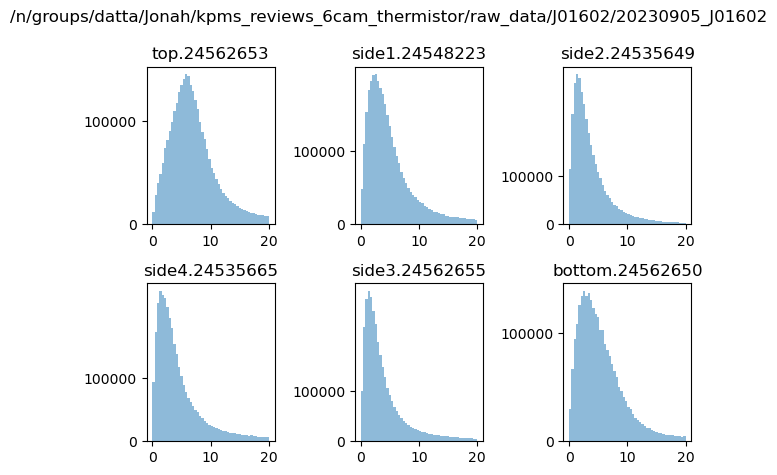

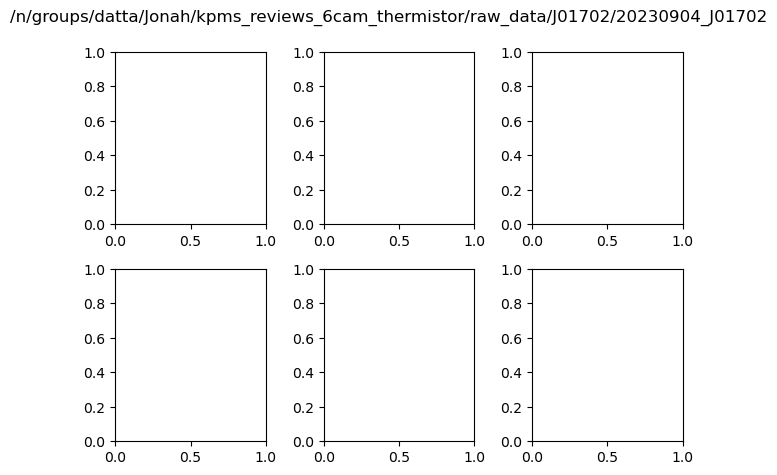

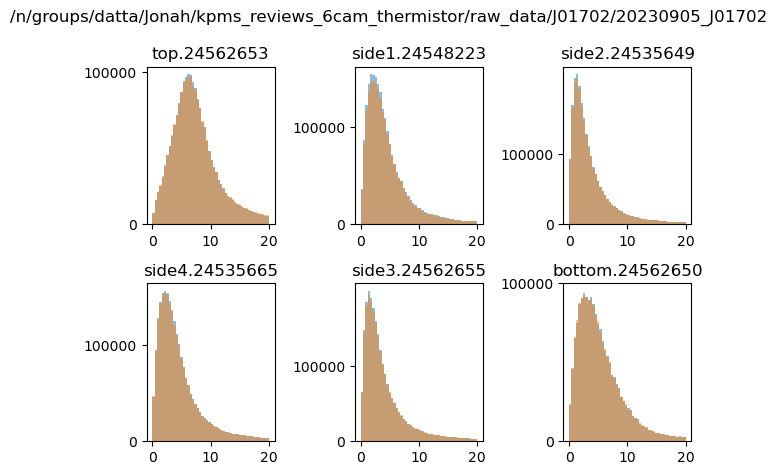

In [50]:
# Re-load and look at errors
for video_dir, calib_dir in calib_dict.items():
    
#     if "20230908_J01703" not in video_dir: continue
        
    print(video_dir, calib_dir)
    fig, axs = plt.subplots(2,3)
    
    for suffix in ['', '.COMPRESSED']:
        
        fname = join(video_dir, 'robust_triangulation' + suffix + '.npy')
        if not exists(fname): 
            print('No triang found, skipping...')
            continue
        
        calib_file = find_file_from_pattern(calib_dir, 'camera_params.h5', [])
        all_extrinsics, all_intrinsics, camera_names = mcc.load_calibration(calib_file, 'gimbal')

        # get og uv's
        all_uvs = []
        for c in camera_names:
            kp_file = join(video_dir, c + suffix + '.keypoints.h5')
            with h5py.File(kp_file,'r') as h5:
                uvs = h5['uv'][()]
                confs = h5['conf'][()]
                uvs[confs < 0.25] = np.nan
                all_uvs.append(uvs)
        all_uvs = np.array(all_uvs)
        
        # get new ones
        poses = np.load(fname)
        
        
        # calc re-projn error
        y_per_cam = [mcc.project_points(poses, all_extrinsics[iCam], *all_intrinsics[iCam]) for iCam in range(all_uvs.shape[0])]
        err_per_cam = [np.sqrt(((all_uvs[iCam,...][:len(y_per_cam[iCam])] - y_per_cam[iCam])**2).sum(-1)) for iCam in range(all_uvs.shape[0])]
        
        # plot
        for err,ax,cam in zip(err_per_cam, axs.ravel(), camera_names):
            print(np.sum(~np.isnan(err))/err.size)
            _ = ax.hist(err.ravel(), range=(0,20), bins=50, alpha=0.5, label=suffix)
#             _ = ax.hist(err.ravel(), bins=50, alpha=0.5)
            ax.set(
                title=cam,
                yticks=[0,1e5]
            )
    plt.suptitle(video_dir)
    plt.tight_layout()
#     plt.xlabel('Triangulation re-projn error')
#     plt.legend()
    